In [2]:
import os
import random
import json
import shutil
import warnings
from collections import Counter

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import seaborn as sns
from pytorch_lightning import seed_everything
from pytorch_lightning.metrics.functional import accuracy, f1, confusion_matrix
from pytorch_lightning.metrics import ConfusionMatrix
from PIL import Image
from matplotlib import pyplot as plt

from models import EfficientNet
from data import BeardData, BeardDataModule
from config import SEED, DATA_PATH, NUM_CLASSES, BATCH_SIZE, IMAGE_SIZE, TEST_SIZE
from transforms import transform

seed_everything(SEED)
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
def create_dataset(data_path, test_size=TEST_SIZE):
    print('Creating train and test directories ...')
    os.makedirs(os.path.join(data_path, 'train'), exist_ok=True)
    os.makedirs(os.path.join(data_path, 'test'), exist_ok=True)
    train_dir = os.path.join(data_path, 'train')
    test_dir = os.path.join(data_path, 'test')

    json_file = open(os.path.join(data_path, 'labels_for_test.json'))
    labels_dict = json.load(json_file)

    print('Creating label directories ...')
    unique_labels = np.unique(list(labels_dict.values()))
    for data_part in ['train', 'test']:
        for label in unique_labels:
            os.makedirs(os.path.join(data_path, data_part, label), exist_ok=True)

    all_filenames = list(labels_dict.keys())
    np.random.seed(SEED)
    np.random.shuffle(all_filenames)
    test_len = int(len(all_filenames) * test_size)
    train_filenames = all_filenames[:-test_len]
    test_filenames = all_filenames[-test_len:]

    print('Moving files ...')
    images_dir = os.path.join(data_path, 'data_for_test')
    for filename in train_filenames:
        src = os.path.join(images_dir, filename)
        dst = os.path.join(train_dir, labels_dict[filename], filename)
        shutil.move(src, dst)

    for filename in test_filenames:
        src = os.path.join(images_dir, filename)
        dst = os.path.join(test_dir, labels_dict[filename], filename)
        shutil.move(src, dst)

def visualize_data(data):
    n = 5
    indices = random.sample(range(0, len(data)), n)
    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(20, 20))
    for i, idx in enumerate(indices):
        image, target = data[idx]
        axes[i].imshow(image)
        axes[i].set_title(idx_to_labels[target])
        
    plt.show()

def show_targets_hist(targets, title=''):
    count_labels = dict(Counter(targets).most_common())
    plt.figure(figsize=(15, 5))
    plt.title(title)
    sns.barplot(x='labels', y='num_samples', data=pd.DataFrame({'labels': [idx_to_labels[idx] for idx in count_labels.keys()], 'num_samples': list(count_labels.values())}))

In [4]:
# create_dataset(DATA_PATH)

In [5]:
train_data = BeardData(data_path=DATA_PATH)
test_data = BeardData(data_path=DATA_PATH, train=False)
labels_to_idx = train_data.labels_to_idx.copy()
idx_to_labels = train_data.idx_to_labels.copy()

In [ ]:
visualize_data(train_data)

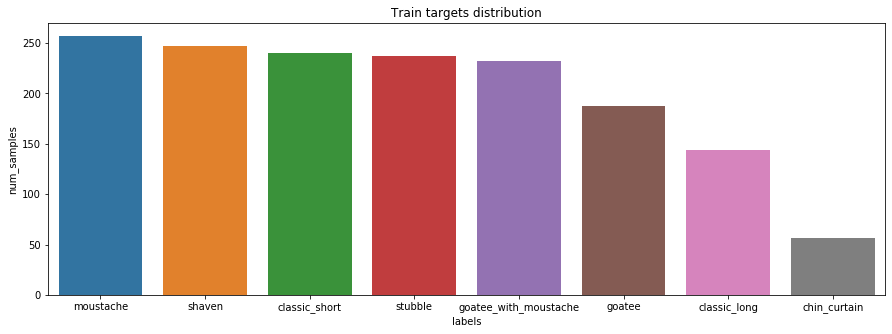

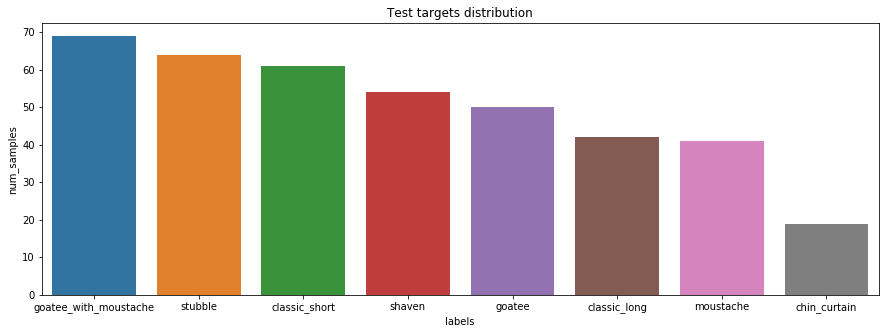

In [7]:
show_targets_hist(train_data.targets, title='Train targets distribution')
show_targets_hist(test_data.targets, title='Test targets distribution')

In [8]:
def estimate_model(model, dataloader):
    def compute_metrics(pred, target):
        metrics = dict()
        metrics['accuracy'] = accuracy(pred, target, num_classes=NUM_CLASSES)
        metrics['f1'] = f1(pred, target, num_classes=NUM_CLASSES)
        return metrics

    acc_scores = []
    f1_scores = []
    confusion_matrix = ConfusionMatrix(num_classes=NUM_CLASSES, normalize='true')
    for batch in dataloader:
        data, target = batch
        pred = model(data)
        metrics = compute_metrics(pred, target)
        acc_scores.append(metrics['accuracy'])
        f1_scores.append(metrics['f1'])
        confusion_matrix.update(pred, target)

    mean_acc = np.sum(acc_scores) / len(dataloader)
    mean_f1 = np.sum(f1_scores) / len(dataloader)

    return mean_acc, mean_f1, confusion_matrix.compute()

In [9]:
CHECKPOINT_PATH = 'checkpoints/best.ckpt'
MODEL_NAME = 'efficientnet-b4'

dm = BeardDataModule(DATA_PATH, batch_size=BATCH_SIZE)
dm.setup()
checkpoint = torch.load(CHECKPOINT_PATH)
model = EfficientNet(MODEL_NAME, NUM_CLASSES)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

test_acc, test_f1, confusion_matrix = estimate_model(model, dm.test_dataloader())
print('Test accuracy: ', test_acc)
print('Test F1: ', test_f1)

Loaded pretrained weights for efficientnet-b4
Test accuracy:  0.83
Test F1:  0.83


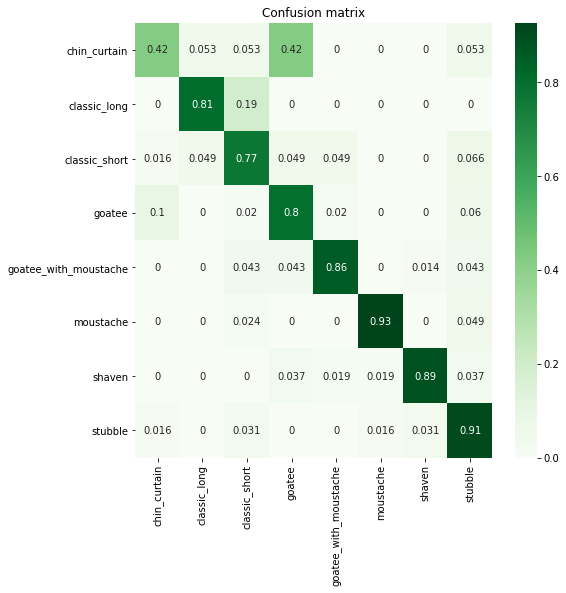

In [10]:
labels = list(idx_to_labels.values())
data = pd.DataFrame(data=confusion_matrix.numpy(), columns=labels, index=labels)
plt.figure(figsize=(8, 8))
plt.title('Confusion matrix')
sns.heatmap(data, annot=True, cmap='Greens')
plt.show()

In [11]:
def predict(model, image):
    img_tensor = transform()(image).unsqueeze_(0)
    prediction = torch.argmax(F.softmax(model(img_tensor))).item()
    return prediction

def show_predictions(model, data, n=3):
    indices = random.sample(range(0, len(data)), n)
    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(20, 20))
    for i, idx in enumerate(indices):
        image, target = data[idx]
        target_label = data.idx_to_labels[target]
        pred_id = predict(model, image)
        pred_label = data.idx_to_labels[pred_id]
        axes[i].imshow(image)
        axes[i].set_title(f'Pred: {pred_label} | target: {target_label}')    

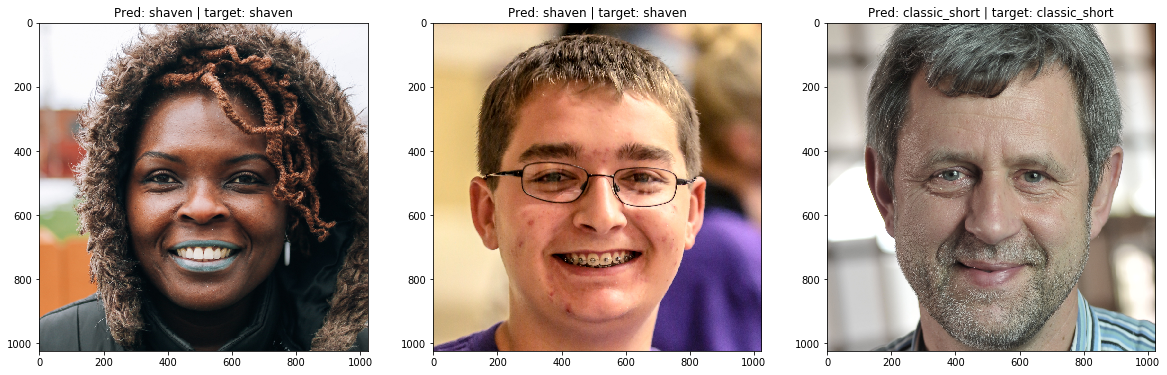

In [12]:
show_predictions(model, test_data)

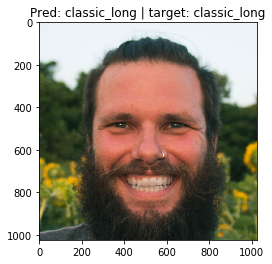

In [13]:
idx = 9
image, target = test_data[idx]
target_label = test_data.idx_to_labels[target]
pred_label = test_data.idx_to_labels[predict(model, image)]
plt.title(f'Pred: {pred_label} | target: {target_label}')
plt.imshow(image)
plt.show()

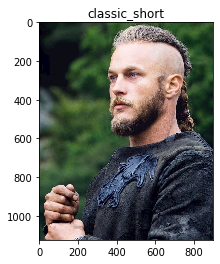

In [14]:
image_path = './dataset/example.jpg'
image = Image.open(image_path).convert('RGB')
pred_label = idx_to_labels[predict(model, image)]

plt.imshow(image)
plt.title(pred_label)
plt.show()

### Summary
* Best model achieved 83% by accuracy and F1 on test set.
* According to confusion matrix for every class except _chin curtain_ model has accuracy between 77% and 93%.
* Experimented with ResNets (18, 34, 50) and EfficientNets (b3, b4, b5). Best results: __EfficientNet-B4__.
* Experimented with optimizers: Adam, AdamW, RAdam + Lookahead, SGD. Best results: __AdamW__.
* Experimented with LR schedulers: ReduceLROnPlateau, ExponentialLR, StepLR, MultiStepLR. Best results: __MultiStepLR__.
* Used samplers: SubsetRandomSampler and WeightedRandomSampler (to prevent class imbalance). Best results: __SubsetRandomSampler__.
* Applied augmentations: horizontal flip, shift, scale, rotation, random brightness and contrast. Best results: __without augmentations__.  